In [18]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pathlib import Path
import json
import pickle

## 1. Предобработка временного ряда

In [16]:
#ROOT_DIR = Path.cwd().resolve().parent
ROOT_DIR = Path.cwd().resolve()
DATA_DIR = ROOT_DIR / 'data'
MODELS_DIR = ROOT_DIR / 'models'
PREDICTIONS_DIR = ROOT_DIR / 'predictions'

y = pd.read_excel(DATA_DIR / 'data1_logs_hourly.xlsx', index_col=0)

## 2. Анализ временного ряда

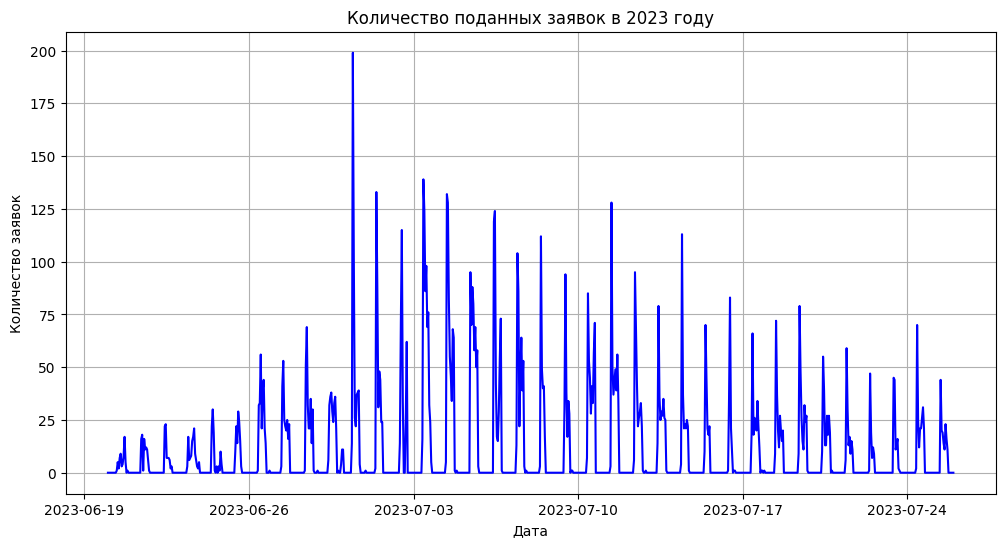

In [ ]:
y2023 = y[y.index.year == 2023]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y2023.index, y2023, color='blue')

ax.set_xlabel('Дата')
ax.set_ylabel('Количество заявок')
ax.set_title('Количество поданных заявок в 2023 году')

locator = mdates.WeekdayLocator(byweekday=mdates.MO)
ax.xaxis.set_major_locator(locator)

ax.grid()
plt.show()

In [ ]:
y_train = y[(y.index.year >= 2014) & (y.index.year <= 2023)]
y_train = y_train[(y_train.index.month == 6) & (y_train.index.day >= 20) |
                  (y_train.index.month == 7) & (y_train.index.day <= 25)]

y2024 = y[(y.index >= '2024-06-20') & (y.index <= '2024-07-25 23:00:00')]

### 2.1. Проверка стационарности ряда

In [ ]:
# ADF-тест. H0: ряд нестационарен
adf_stat, adf_p, *_ = adfuller(y_train)
print(f"ADF p-value: {adf_p:.4f}")
# KPSS-тест. H0: ряд стационарен
kpss_stat, kpss_p, *_ = kpss(y_train)
print(f"KPSS p-value: {kpss_p:.4f}")

ADF p-value: 0.0000
KPSS p-value: 0.0315


### 2.2. Выбор начальных $p$ и $q$

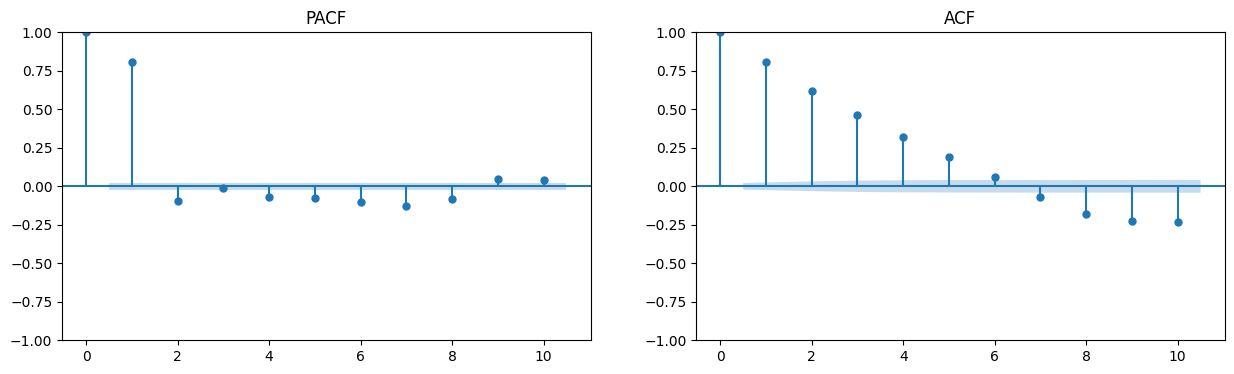

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

sm.graphics.tsa.plot_pacf(y_train, lags=10, ax=axes[0])
axes[0].set_title('PACF')

sm.graphics.tsa.plot_acf(y_train, lags=10, ax=axes[1])
axes[1].set_title('ACF')

plt.show()

p = 1, q = 2

## 3. Обучение модели

### 3.1. Без преобразований

In [ ]:
model = pm.auto_arima(
    y_train,
    seasonal=True,
    m=24,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=None,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=22.82 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=69454.566, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=67076.028, Time=14.17 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=67980.732, Time=15.96 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=69452.566, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=69455.801, Time=0.30 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=66315.029, Time=35.23 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=66.02 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=26.83 sec
 ARIMA(0,1,0)(2,0,0)[24] intercept   : AIC=66471.997, Time=29.49 sec
 ARIMA(2,1,0)(2,0,0)[24] intercept   : AIC=66031.928, Time=47.10 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=66788.018, Time=21.54 sec
 ARIMA(2,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=92.16 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=65017.814, Time=37.24 sec
 ARIMA(2,1,0)(0,0,

In [19]:
model = sm.tsa.ARIMA(y_train, order=(3, 1, 0), seasonal_order=(1, 0, 1, 7))
model = model.fit()
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 8630
Model:             ARIMA(3, 1, 0)x(1, 0, [1], 7)   Log Likelihood              -34652.697
Date:                           Mon, 21 Apr 2025   AIC                          69317.394
Time:                                   07:16:35   BIC                          69359.771
Sample:                                        0   HQIC                         69331.844
                                          - 8630                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0327      0.006     -5.893      0.000      -0.044      -0.022
ar.L2         -0.1134      0.007    -16.408

- Присутствует гетероскедастичность

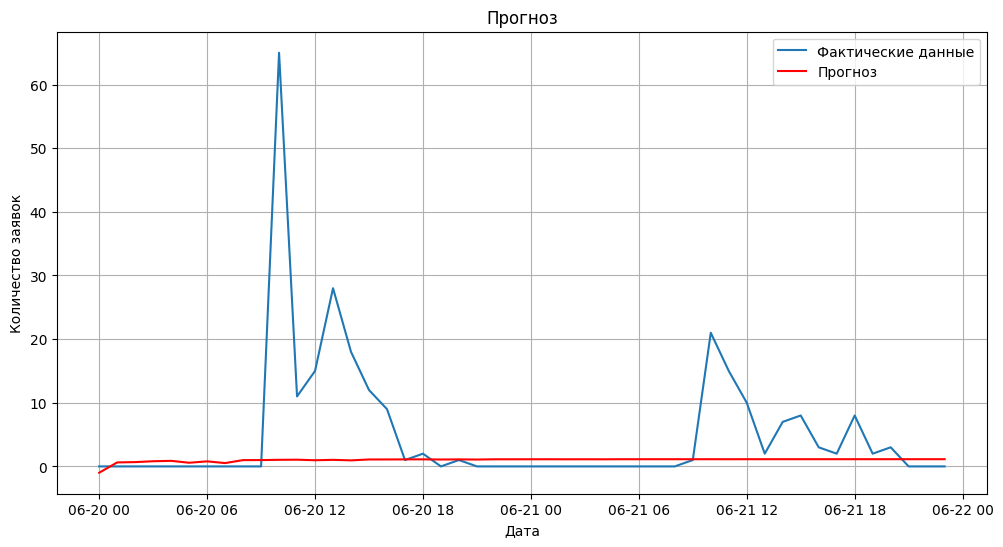

In [20]:
forecast_res = model.get_forecast(steps=48)
predicted_mean = forecast_res.predicted_mean
conf_int = forecast_res.conf_int()

plt.figure(figsize=(12,6))
plt.plot(y2024[:48].index, y2024[:48], label="Фактические данные")
plt.plot(y2024[:48].index, predicted_mean, label="Прогноз", color='red')
plt.xlabel("Дата")
plt.ylabel("Количество заявок")
plt.title("Прогноз")
plt.legend()
plt.grid()
plt.show()

In [21]:
history = y_train.copy()
predictions = []

for start in range(0, len(y2024), 24):
    end = min(start + 24, len(y2024))

    model = sm.tsa.SARIMAX(
        history,
        order=(3, 1, 0),
        seasonal_order=(1, 0, 1, 24),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    forecast = model.forecast(steps=end - start)
    predictions.extend(forecast)

    new_data = y2024[start:end]
    history = pd.concat([history, new_data])

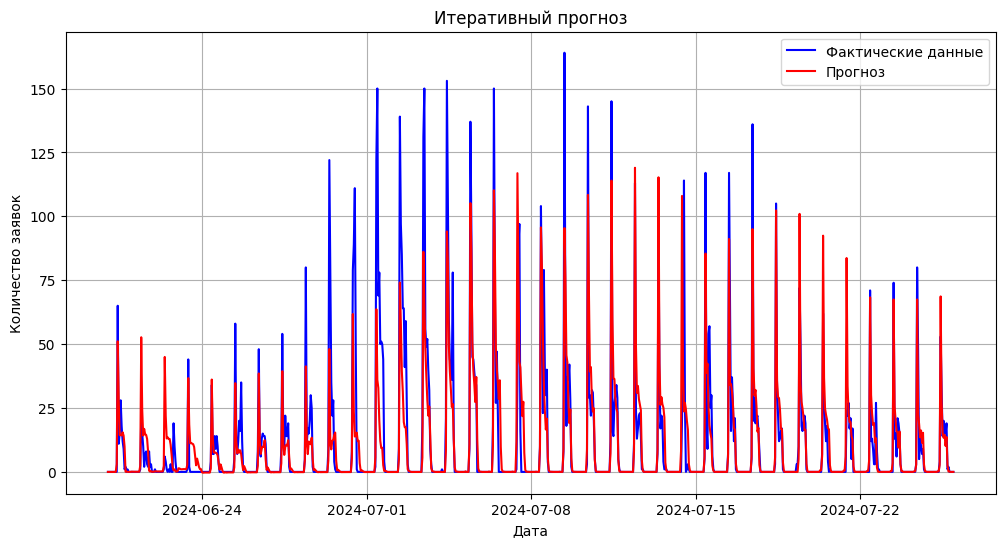

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y2024.index, y2024, label='Фактические данные', color='blue')
ax.plot(y2024.index, predictions, label='Прогноз', color='red')

ax.set_xlabel('Дата')
ax.set_ylabel('Количество заявок')
ax.set_title('Итеративный прогноз')

locator = mdates.WeekdayLocator(byweekday=mdates.MO)
ax.xaxis.set_major_locator(locator)

ax.legend()
ax.grid()
plt.show()

In [23]:
rmse = np.sqrt(mean_squared_error(y2024, predictions))
mae = mean_absolute_error(y2024, predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 14.160901832078594
MAE: 5.710401678447978


### 3.2. Log-преобразование

In [26]:
y_log = np.log1p(y_train)

model_log = pm.auto_arima(
    y_log,
    seasonal=True,
    m=24,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=None,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=43.58 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=32132.295, Time=0.11 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=16892.329, Time=23.33 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=22090.264, Time=17.47 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=35022.565, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=21391.723, Time=0.51 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=50.34 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=62.89 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=18785.533, Time=18.41 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=157.48 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=24077.664, Time=10.40 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=16881.666, Time=28.73 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=21119.094, Time=0.56 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=57.22 sec
 ARIMA(2,0,0)(1,0,1)[24]

In [27]:
print(model_log.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 8630
Model:             SARIMAX(3, 0, 2)x(2, 0, [], 24)   Log Likelihood               -8089.328
Date:                             Mon, 21 Apr 2025   AIC                          16196.656
Time:                                     08:13:16   BIC                          16260.223
Sample:                                          0   HQIC                         16218.332
                                            - 8630                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0291      0.016      1.823      0.068      -0.002       0.060
ar.L1          0.6011      

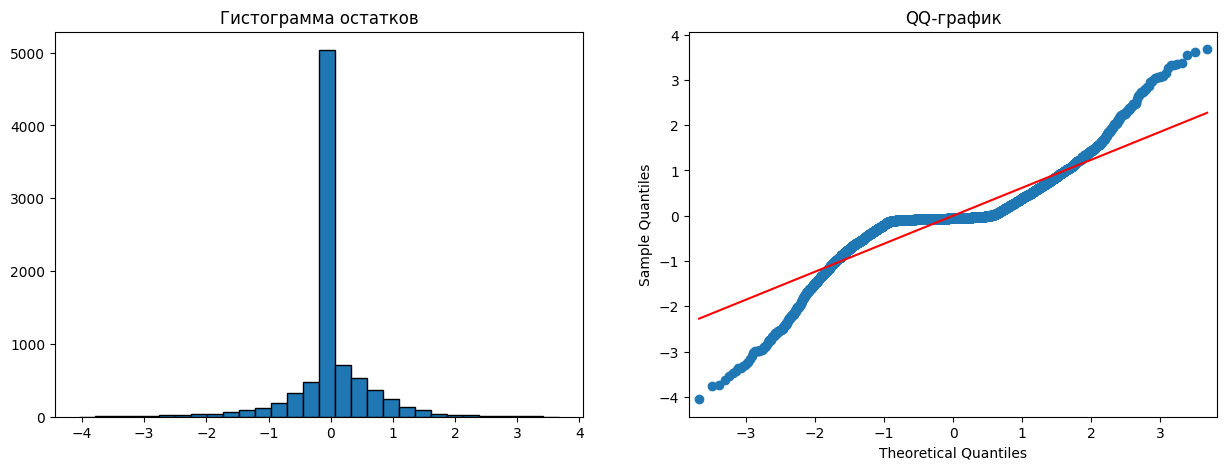

In [28]:
residuals = model_log.resid()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(residuals, bins=30, edgecolor='black')
ax[0].set_title('Гистограмма остатков')

sm.qqplot(residuals, line='s', ax=ax[1])
ax[1].set_title('QQ-график')

plt.show()

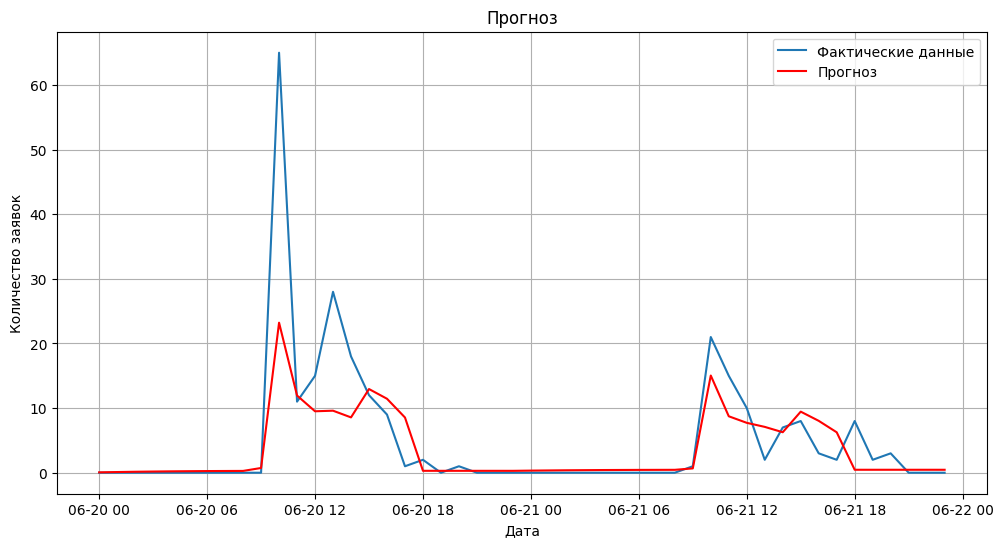

In [29]:
forecast_log = model_log.predict(n_periods=48)
forecast = np.expm1(forecast_log)

plt.figure(figsize=(12, 6))
plt.plot(y2024[:48].index, y2024[:48], label='Фактические данные')
plt.plot(y2024[:48].index, forecast, label='Прогноз', color='red')
plt.xlabel('Дата')
plt.ylabel('Количество заявок')
plt.title('Прогноз')
plt.legend()
plt.grid()
plt.show()

In [30]:
y_log_train = np.log1p(y_train)

history_log = y_log_train.copy()
predictions = []

for start in range(0, len(y2024), 24):
    end = min(start + 24, len(y2024))

    model_log = sm.tsa.SARIMAX(
        history_log,
        order=(3, 0, 2),
        seasonal_order=(2, 0, 0, 24),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    forecast_log = model_log.forecast(steps=end - start)
    forecast = np.expm1(forecast_log)

    predictions.extend(forecast)

    new_data_log = np.log1p(y2024[start:end])
    history_log = pd.concat([history_log, new_data_log])

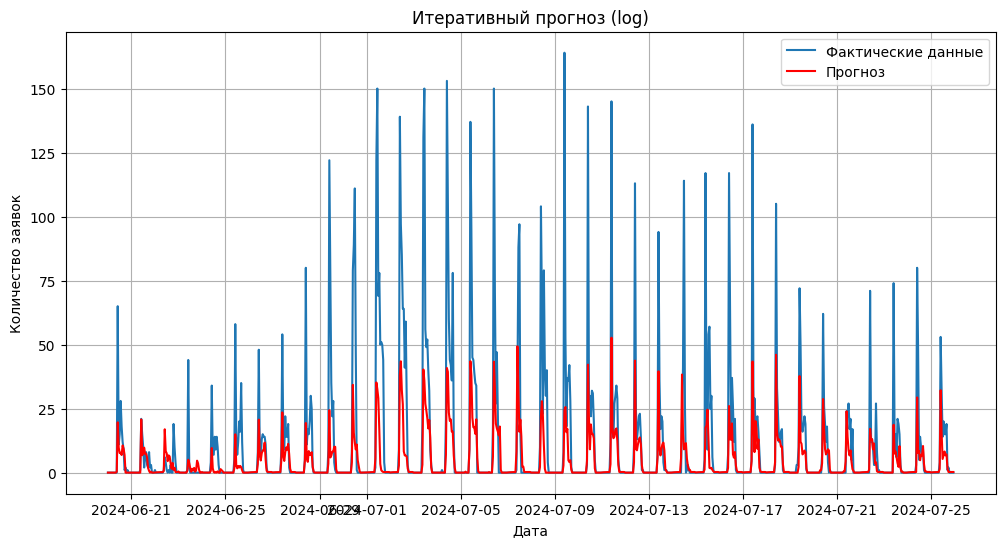

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(y2024.index, y2024, label='Фактические данные')
plt.plot(y2024.index, predictions, label='Прогноз', color='red')
plt.xlabel('Дата')
plt.ylabel('Количество заявок')
plt.title('Итеративный прогноз (Log-преобразование)')
plt.legend()
plt.grid()
plt.show()

In [32]:
rmse = np.sqrt(mean_squared_error(y2024, predictions))
mae = mean_absolute_error(y2024, predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 19.933217287281803
MAE: 7.505983135215144


In [35]:
# Остановимся на модели без преобразований данных
with open(MODELS_DIR / "arima_hourly_model.pkl", "wb") as file:
    pickle.dump(model, file)

with open(PREDICTIONS_DIR / "arima_hourly_predictions.json", "w") as file:
    json.dump(predictions, file)